# Прогнозування результатів перегонів за допомогою методу K-nearest Neighbours

Імпортуємо бібліотеки

In [419]:
import pandas as pd
from dotenv import dotenv_values
from sqlalchemy import create_engine, text

Завантажуємо змінні оточення з .env файлу для з'єднання зі сховищем

In [420]:
config = dotenv_values()

DB_NAME = config.get('DB_NAME')
DB_USER = config.get('DB_USER')
DB_HOST = config.get('DB_HOST')
DB_PASSWORD = config.get('DB_PASSWORD')
DB_PORT = config.get('DB_PORT')

З'єднуємося з базою даних

In [421]:
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

Завантажимо дані зі сховища

In [422]:
def get_data(season):
    query = f"""
        SELECT
            d.id AS driver_id,
            r.round AS round,
            d.name AS driver_name,
            fp1.position_number AS fp1_result,
            fp2.position_number AS fp2_result,
            fp3.position_number AS fp3_result,
            q.position_number AS q_result,
            rr.grid_position_number AS grid_position,
            rr.position_number AS finish_position
        FROM 
            drivers d
        JOIN 
            races_fp1_results fp1 ON d.id = fp1.driver_id
        JOIN 
            races_fp2_results fp2 ON d.id = fp2.driver_id
        JOIN 
            races_fp3_results fp3 ON d.id = fp3.driver_id
        JOIN 
            races_qualifying_results q ON d.id = q.driver_id
        JOIN 
            races_race_results rr ON d.id = rr.driver_id
        JOIN 
            races r ON fp1.race_id = r.id AND fp2.race_id = r.id AND fp3.race_id = r.id AND q.race_id = r.id AND rr.race_id = r.id
        JOIN
            seasons s ON s.id = r.season_id
        WHERE 
            s.year = :season
    """
    
    with engine.connect() as connection:
        df = pd.read_sql(text(query), connection, params={'season': season})
    
    return df

In [423]:
df = get_data(2019)
df.head()

,driver_id,round,driver_name,fp1_result,fp2_result,fp3_result,q_result,grid_position,finish_position
0,872,1,Valtteri Bottas,5,2,7,2.0,2.0,1.0
1,551,1,Lewis Hamilton,1,1,1,1.0,1.0,2.0
2,606,1,Max Verstappen,4,3,9,4.0,4.0,3.0
3,807,1,Sebastian Vettel,2,5,2,3.0,3.0,4.0
4,143,1,Charles Leclerc,3,9,3,5.0,5.0,5.0


In [424]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [425]:
df = df.dropna()
features = ['fp1_result', 'fp2_result', 'fp3_result', 'q_result', 'grid_position']
X = df[features]
y = df['finish_position']

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабування ознак: Дані масштабуються для поліпшення результатів моделювання. Ознаки нормалізуються до середнього значення 0 та стандартного відхилення 1.

In [427]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Підбір гіперпараметрів (k): Використовуються цикл та крос-валідація для вибору найкращого значення гіперпараметра k для моделі k-найближчих сусідів (KNN).

In [428]:
results = {'best_n': 0, 'max_accuracy': 0}
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    if results['max_accuracy'] < accuracy:
        results = {'best_n': k, 'max_accuracy': accuracy}

n = results['best_n']    

print('Best n_neighbours:', n)

Best n_neighbours: 26


Класифікація та оцінка моделі: Модель KNN навчається на тренувальних даних, після чого здійснюється передбачення на тестових даних. Оцінюється точність моделі за допомогою метрик accuracy_score, classification_report та confusion_matrix.

In [429]:
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=26)

In [430]:
y_pred = knn.predict(X_test_scaled)

In [431]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.18


Точність моделі становить всього 18%, що є досить низьким значенням. Це означає, що модель не дуже ефективна в передбаченні позицій гонщиків у вказаному сезоні.
Проте слід враховувати, що точність рахується по тих значеннях, що точно співали, тобто коли модель спрогнозувала саме ту позицію, на якій гонщик насправді і фінішував.
Якщо модель спрогнозувала фінішну позицію на 1 вище або нижче ніж насправді цей прогноз уже вважається неточним.
Таким чином, враховуючи певні непередбачувані обставини в гонці, які неможливо спрогнозувати, модель непогано справляється з прогнозуванням приблизних очікуваних об'єктивних результатів.

In [432]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         1.0       0.33      0.75      0.46         4
         2.0       0.33      1.00      0.50         1
         3.0       1.00      0.20      0.33         5
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         6
         6.0       0.40      0.29      0.33         7
         7.0       0.29      1.00      0.44         2
         8.0       0.20      0.25      0.22         4
         9.0       0.14      0.33      0.20         3
        10.0       0.00      0.00      0.00         6
        11.0       0.00      0.00      0.00         3
        12.0       0.00      0.00      0.00         6
        13.0       0.00      0.00      0.00         4
        14.0       0.00      0.00      0.00         2
        15.0       0.00      0.00      0.00         4
        16.0       0.17      0.50      0.25         2
        17.0       0.00      0.00      0.00         5
    

c:\Users\zagrebelnio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zagrebelnio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zagrebelnio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Оцінка моделі для кожного класу показує нерівномірність результатів. Наприклад, для позиції 2 модель має 100% точність, але для позицій 4, 5, 10, 11, тощо, вона має точність 0%. Це вказує на недостатню ефективність моделі в передбаченні певних класів позицій.

In [433]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 3 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 2 1 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 2 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 1 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 2 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


За матрицею плутанини видно, що модель має тенденцію переважати деякі класи позицій (наприклад, позицію 1 та позицію 6), тоді як для інших класів вона здійснює менш точні передбачення.

In [434]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df.head(10)

,Actual,Predicted
9,10.0,8.0
186,13.0,14.0
160,7.0,7.0
50,12.0,14.0
110,15.0,16.0
118,3.0,3.0
100,5.0,4.0
327,16.0,16.0
374,6.0,4.0
255,3.0,1.0


Візуалізація: Побудований графік розсіювання демонструє відповідність між фактичними та передбаченими позиціями гонщиків. Кожна точка на графіку відображає позицію у фактичному та передбаченому результатах. Червона пунктирна лінія відображає ідеальну відповідність, де фактична позиція рівна передбаченій.

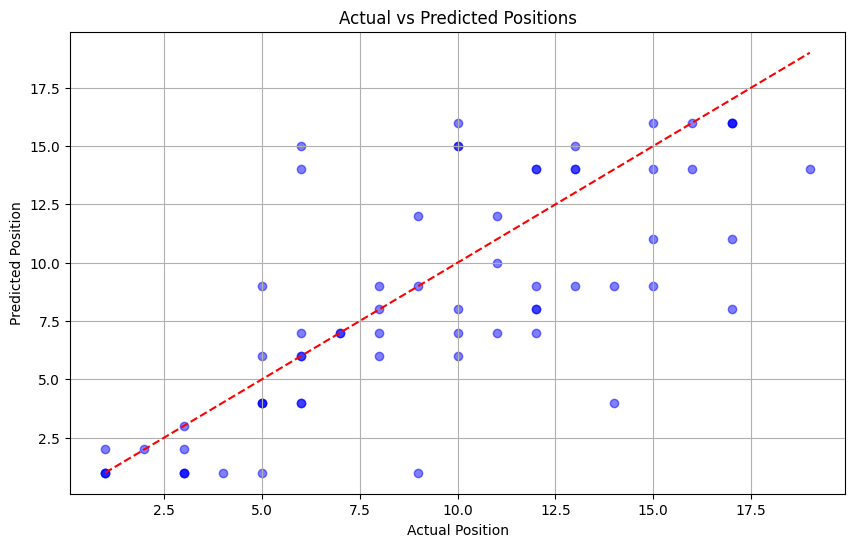

In [435]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], color='blue', alpha=0.5)
plt.plot([min(comparison_df['Actual']), max(comparison_df['Actual'])], 
         [min(comparison_df['Actual']), max(comparison_df['Actual'])], 
         color='red', linestyle='--')
plt.title('Actual vs Predicted Positions')
plt.xlabel('Actual Position')
plt.ylabel('Predicted Position')
plt.grid(True)
plt.show()

Візуалізація таблиці: У даному випадку, виконується відфільтровання та сортування даних для конкретного раунду гонки. Виводиться таблиця з даними про ім'я гонщика, номер раунду, фактичну та передбачену позиції.

In [436]:
driver_names = df.loc[X_test.index]['driver_name'].tolist()
rounds = df.loc[X_test.index]['round'].tolist()

visualization_df = pd.DataFrame({'Driver Name': driver_names,
                                 'Round': rounds,
                                 'Actual Position': y_test.values,
                                 'Predicted Position': y_pred})

round = 1
filtered_df = visualization_df[visualization_df['Round'] == round]
sorted_df = filtered_df.sort_values(by='Actual Position')
sorted_df.head(20)

,Driver Name,Round,Actual Position,Predicted Position
60,Sebastian Vettel,1,4.0,1.0
20,Kevin Magnussen,1,6.0,7.0
54,Kimi Räikkönen,1,8.0,6.0
0,Daniil Kvyat,1,10.0,8.0
51,Robert Kubica,1,17.0,16.0


## Висновки

Отже, в цілому, можна сказати, що модель потребує додаткового налаштування та покращень для досягнення кращих результатів у передбаченні позицій гонщиків.